# Port of columnsfmri to python including jupyter demo

Import model implementation from columnsfmri.py and other useful modules.

In [13]:
import columnsfmri
import numpy as np
import importlib

Inititialize simulation using a 512 x 512 grid on an area of 24 x 24 mm. 

In [3]:
N = 512; L = 24
s = columnsfmri.sim(N,L)

Simulate a column pattern by filtering Gaussian white noise. Rho is the main pattern frequency, delta specifies the amount of irregularity.

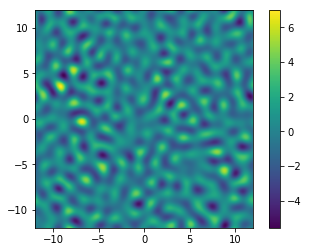

In [4]:
gwn = s.gwnoise()
rho,deltaRelative = 0.5,0.5
columnPattern = s.columnPattern(rho,deltaRelative,gwn)
s.plotPattern(columnPattern)

Simulate a spatial BOLD response with a FWHM of 2 mm, and an average response amplitude of 5%.

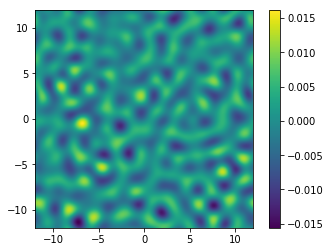

In [5]:
fwhm = 2
beta = 0.05
boldPattern,_,_ = s.bold(fwhm,beta,columnPattern)
s.plotPattern(boldPattern)

Simulate MRI sampling using a voxel width of 3 mm. (We first add the relative response pattern to a constant background of 1).

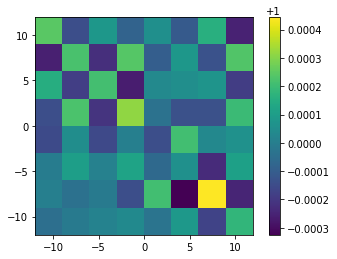

In [6]:
w = 3
mriPattern = s.mri(w,1+boldPattern)
s.plotVoxels(mriPattern)

The amount of functional contrast can be quantified as the standard deviation of the imaged responses (contrast range).

In [9]:
c = np.std(mriPattern)
print(str(100*c)+"%")

0.016466979141782145%


In [35]:
importlib.reload(columnsfmri)
columnsfmri.noiseModel(1,2,100,True,noiseType='Physiological')

inf 0.0113 1.939


In [25]:
np.Inf

inf